<a href="https://www.kaggle.com/code/noahnguyen08/coloring-grayscale-images?scriptVersionId=139357204" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Colorizing Grayscale Images

(insert image here)

Nowadays, there has been a lot of different tools and applications that edit your pictures seamlessly. You can use those to make funny photoshops, amazing AI generated photos, or even colorize the black & white images that you took from 50 years ago! But have you ever thought how all those tools were built under the hood? 

In this notebook, we will dive into the why, the how, and the mathematical aspects of human's perception of colors. We will explore a color space that mimics human's perception of colors better and better as we go deeper into the notebook.

**Additional notes**: In this notebook, the math of how transferring among color spaces works is not required in order to understand the project, so feel free to skip any 'mathy' parts :)

**Prerequisite**: Understanding of basic linear algebra
* Vector, Matrix muliplication
* Transpose matrix
* Linear transformation, non-linear transformation

## Outline
##### 1. Introduction to color spaces
* Grayscale color space
* RGB color space
* XYZ color space
* Lab color space

##### 2. Data preprocessing
* Identify the input of the model
* Convert into appropriate color space
* Feature scaling

##### 3. Train model
* Identify the appropriate model to find the colors for the input

##### 4. Diagnostics (bias, variance, error analysis)


## What are Grayscale images?

(insert image here)

Simply, a Grayscale image consists of different shades of gray, ranging from pure black to pure white. It's called 'Grayscale' as we only see black and white colors, but no colors like Red, Green, Blue.

To make things clear, think of a black and white image on a TV from the 1950s, compared to a colored image on the TV in your house right now.

### Grayscale image as Matrix representation
Now the Grayscale image can be represented as a 2D image of width and height, with only 1 channel, as there are only black and white colors.

In mathematical terms, they are represented as a matrix with row and column. Each element stands for the pixel value, ranges from 0 to 255. It's also the range of the shades of gray, from pure black to pure white, respectively.

(insert image here)

Source: https://www.researchgate.net/figure/Matrix-for-certain-area-of-a-grayscale-image-17_fig3_325569674

* 0 = pure black
* 255 = pure white

This explanation will be used to define a Grayscale image as a NumPy array later in this notebook.



## Why RGB images?
(insert image here)

Source:https://www.bbc.co.uk/news/business-46125741

Before the outbreak of technology, we usually watch TVs with a screen with only Grayscale images. RGB images are born after many researches on human's perception of colors, with the purpose of bringing
more realistic visuals to people.

Nowadays, RGB images are used for images display in our electronic devices.

## What is the LAB color space?
We have introduced the RGB color space, which is used to approximate human's perception of colors. But there's another color space that does the same job but performs much more accurate: LAB color space.

(insert image here)

Really, the only difference of LAB color space is that it can approximate to human's vision better than RGB does. But here comes the more interesting part: How differently does LAB function compared to RGB?

### What do components in the LAB color space mean?
To make everything clear, we will compare the difference of the functionality between RGB and LAB.

**RGB**: it's separated into 3 components
* R: red channel 
* G: green channel
* B: blue channel

Each channel ranges from 0 to 255, representing the amount of contribution of that color to the RGB image

**LAB**: it's separated into 3 components
* L: lightness channel, ranging from 0 to 100, with 0 of black, and 100 of white
* a: green-red channel, ranging from -a (green), to a (red)
* b: yellow-blue channel, ranging from -b (blue), to b (yellow)

### Okay, so how does LAB perform better than RGB exactly?
This is related to our human's visual system. In the RGB color space, its channels only represent the intensity of a single color to create a colored image. However, human doesn't perceive color in a linear fashion. We see colors in pairs: green-red, blue-yellow; therefore, we need a non-linear color space that constructs these pairs. Thus, LAB color space is designed. 

Now imagine a random color point in the figure above. This color point is the point where we are looking with our eyes at. It's values are in the following:
* x-axis: a value that hues between green and red
* y-axis: a value that hues between blue and yellow
* z-axis: a value that hues between black and white

We can see a color point in the LAB color space has a variation of all green, red, blue, yellow, and the lightness colors. This is exactly how human's vision works.


### Why LAB?
LAB is made up from L, a, b channels, and the L channel is exactly the grayscale channel, which will be passed in as the input for the model, and the target will be the ab channels stacked on top of each other. Thus, a transformation from RGB color space to LAB color space is preferred.

## Import libraries

In [45]:
from PIL import Image                   # 2D image processing
import numpy as np                      # linear algebra
import matplotlib.pyplot as plt
import tensorflow as tf                 # backend for models
from tensorflow import keras
from keras import Sequential            # deep neural networks
from keras.layers import Dense          # deep NN layers
# from cnn_utils import *
from IPython.display import display     # display images
import os
from os.path import isfile, join
import cv2

# from scipy.ndimage import zoom          # n-dimensional image processing

import pathlib
import imageio

import glob
import math
from keras.layers.merging import concatenate
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb, rgb2gray

## Data Preprocessing
Computers don't process images but numbers, so we have to convert RGB images into pixel values. We will use Pillow library to open each image, and NumPy to represent each image as an array

### Filter out non-RGB  images from dataset

In [46]:
landscape_img = glob.glob('../input/landscape-pictures/*')

# tranpose the array
landscape_img = np.array(landscape_img)
print(landscape_img)

print(f"\nNumber of images: {landscape_img.shape[0]}")

['../input/landscape-pictures/00000098_(5).jpg'
 '../input/landscape-pictures/00000503.jpg'
 '../input/landscape-pictures/00000888.jpg' ...
 '../input/landscape-pictures/00000209_(5).jpg'
 '../input/landscape-pictures/00000369_(6).jpg'
 '../input/landscape-pictures/00000221_(3).jpg']

Number of images: 4319


While filtering the dataset with only checking grayscale, I realized that there are also other types of images, such as CMYK with 4 channels, or even 1-bit pixel images which are not covered in this case. Since we only take RGB images into account, we'll check whether each image is RGB or not.

In [49]:
def is_RGB(single_image):
    '''
    Check whether an image is in RGB or not
    '''
    img = Image.open(single_image, 'r')
    if img.mode == 'RGB':
        return True
    return False

In [50]:
# data preprocessing
def filter_img(image):
    '''
    Filter out any grayscale images from dataset
    '''
    num_images = image.shape[0]
    colored_img = []
    
    for i in range(num_images):
        if is_RGB(image[i]):
            colored_img.append(image[i])
            
    return colored_img

In [51]:
rgb_img = filter_img(landscape_img)
print(f'Number of colored landscape images: {len(rgb_img)}')

Number of colored landscape images: 4315


In [52]:
def extract_input(rgb_images):
    X_img = []
    y_img = []
    
    for img in rgb_images:
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        img = img.astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        
        img_resized = cv2.resize(img, (224, 224))
        img_L = img_resized[:, :, 0]       # extract L channel
        img_ab = img_resized[:, :, 1:]     # extract ab channels
        
        # img_L = img_L / 100
        img_ab = img_ab / 128     # scaled ab channels to range between -1 and 1
        
        X_img.append(img_L)       # input is grayscale channel
        y_img.append(img_ab)      # output is colored, ab channels
        
    
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img, y_img

In [53]:
X, y = extract_input(rgb_img)

### Splitting dataset

In [54]:
from sklearn.model_selection import train_test_split

# split dataset into training, cv, and test sets
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)

# delete temporary variables
del X_, y_

# examine shape
print(f'X_train shape:\n {X_train.shape}')
print(f'\ny_train shape:\n {y_train.shape}')
print(f'\nX_cv shape:\n {X_cv.shape}')
print(f'\ny_cv shape:\n {y_cv.shape}')
print(f'\nX_test shape:\n {X_test.shape}')
print(f'\ny_test shape:\n {y_test.shape}')

X_train shape:
 (2589, 224, 224)

y_train shape:
 (2589, 224, 224, 2)

X_cv shape:
 (863, 224, 224)

y_cv shape:
 (863, 224, 224, 2)

X_test shape:
 (863, 224, 224)

y_test shape:
 (863, 224, 224, 2)


In [55]:
# reshape input and target
def reshape_data(X, y):
    for i in range(len(X)):
        X_ = X[i].reshape(1, 224, 224, 1)
        y_ = y[i].reshape(1, 224, 224, 2)
        yield(X_, y_)

We split proportionally to training, cross-validating, and test sets. Training set should have the most examples to train the model, meanwhile cv set is used to validate the model, and see how well the model performs on unseen data. Test set is used to test everything before. Also, the shapes of the input and target are defined correctly:
​
* input shape has 1 channel (grayscale), thus has no depths
* target shape has 2 channels (ab channels), thus has depth of 2

## Model
We will be using the slightly modified VGG-16 model that's widely used for image processing.

(insert image here)

In [56]:
def colorizing():
    '''
    A modified VGG-16 model that colorizes input grayscale images
    '''
    # specify inputs
    input = tf.keras.Input(shape = (224, 224, 1))                     # fix


    # DOWNSAMPLING

    # 1st Conv layer
    Z1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV1')(input)
    A1 = tf.keras.layers.ReLU()(Z1)
    A1 = tf.keras.layers.BatchNormalization()(A1)

    # 2nd Conv layer
    Z2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV2')(A1)
    A2 = tf.keras.layers.ReLU()(Z2)
    A2 = tf.keras.layers.BatchNormalization()(A2)

#     # 1st Pool layer
#     Z3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding='same', name = 'POOL3')(A2)
#     A3 = tf.keras.layers.BatchNormalization()(Z3)

    # 3rd Conv layer
    Z4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV4')(A2)
    A4 = tf.keras.layers.ReLU()(Z4)
    A4 = tf.keras.layers.BatchNormalization()(A4)

    # 4th Conv layer
    Z5 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV5')(A4)
    A5 = tf.keras.layers.ReLU()(Z5)
    A5 = tf.keras.layers.BatchNormalization()(A5)

#     # 2nd Pool layer
#     Z6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding='same', name = 'POOL6')(A5)
#     A6 = tf.keras.layers.BatchNormalization()(Z6)

    # 5th Conv layer
    Z7 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV7')(A5)
    A7 = tf.keras.layers.ReLU()(Z7)
    A7 = tf.keras.layers.BatchNormalization()(A7)

#     # 3rd Pool layer
#     Z8 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='same', name = 'POOL8')(A7)
#     A8 = tf.keras.layers.BatchNormalization()(Z8)


    # UPSAMPLING

    # 6th Conv layer
    Z9 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV9_TRANSPOSE')(A7)     # unpool
    A9 = tf.keras.layers.ReLU()(Z9)
    A9 = tf.keras.layers.BatchNormalization()(A9)

    # 7th Conv layer
    Z10 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV10_TRANSPOSE')(A9)    # unpool
    A10 = tf.keras.layers.ReLU()(Z10)
    A10 = tf.keras.layers.BatchNormalization()(A10)

#     # 3rd Pool layer
#     Z11 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding='same', name = 'POOL11')(A10)
#     A11 = tf.keras.layers.BatchNormalization()(Z11)

    # 8th Conv layer
    Z12 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV12_TRANSPOSE')(A10)   # unpool
    A12 = tf.keras.layers.ReLU()(Z12)
    A12 = tf.keras.layers.ReLU()(A12)

    # 9th Conv layer
    Z13 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=2, padding='same', name = 'CONV13_TRANSPOSE')(A12)   # unpool
    A13 = tf.keras.layers.ReLU()(Z13)
    A13 = tf.keras.layers.BatchNormalization()(A13)

#     # 4th Pool layer
#     Z14 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding='same', name = 'POOL14')(A13)
#     A14 = tf.keras.layers.BatchNormalization()(Z14)

    # output Conv layer
    output = tf.keras.layers.Conv2DTranspose(filters=2, kernel_size=(3, 3), strides=2, padding='same', activation='tanh', name = 'CONV15_TRANSPOSE')(A13)      # unpool

    # produce the model
    model = tf.keras.Model(inputs = input, outputs = output)
    
    return model

### Loss
CIE76 algorithm in detail: https://en.wikipedia.org/wiki/Color_difference#CMC_l:c_(1984)
​
We typically use RMSE (root mean squared error) loss function for these types of problems, but there is one problem with this loss: It computes the loss in each image, but not in each pixel of each image. The following is a trade-off, but for a higher accuracy and slower performance, we will define an algorithm that computes the color difference between 2 images (predicted vs. ground truth) called CIE76. This CIE76 loss will compare the difference between colors in each pixel of the 2 images.
​
#### Euclidean distance

In [57]:
# compile
colorizing_model = colorizing()
colorizing_model.compile(
    loss = tf.keras.losses.MeanSquaredLogarithmicError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
)

colorizing_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 CONV1 (Conv2D)              (None, 112, 112, 16)      160       
                                                                 
 re_lu_10 (ReLU)             (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_8 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 CONV2 (Conv2D)              (None, 56, 56, 32)        4640      
                                                                 
 re_lu_11 (ReLU)             (None, 56, 56, 32)        0         
                                                           

In [58]:
# train
history = colorizing_model.fit_generator(reshape_data(X_train, y_train), epochs=32, steps_per_epoch=38, verbose=1)

Epoch 1/32


/tmp/ipykernel_32/345381397.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = colorizing_model.fit_generator(reshape_data(X_train, y_train), epochs=32, steps_per_epoch=38, verbose=1)


38/38 [==============================] - 5s 44ms/step - loss: 0.0087
Epoch 2/32
38/38 [==============================] - 2s 45ms/step - loss: 3.3143e-04
Epoch 3/32
38/38 [==============================] - 2s 44ms/step - loss: 9.4332e-05
Epoch 4/32
38/38 [==============================] - 2s 42ms/step - loss: 4.0870e-06
Epoch 5/32
38/38 [==============================] - 2s 42ms/step - loss: 3.6230e-06
Epoch 6/32
38/38 [==============================] - 2s 43ms/step - loss: 1.7787e-06
Epoch 7/32
38/38 [==============================] - 2s 42ms/step - loss: 2.3088e-06
Epoch 8/32
38/38 [==============================] - 2s 43ms/step - loss: 7.7676e-06
Epoch 9/32
38/38 [==============================] - 2s 42ms/step - loss: 1.0416e-06
Epoch 10/32
38/38 [==============================] - 2s 42ms/step - loss: 7.5328e-07
Epoch 11/32
38/38 [==============================] - 2s 42ms/step - loss: 2.5801e-07
Epoch 12/32
38/38 [==============================] - 2s 47ms/step - loss: 9.0747e-07
Epoc

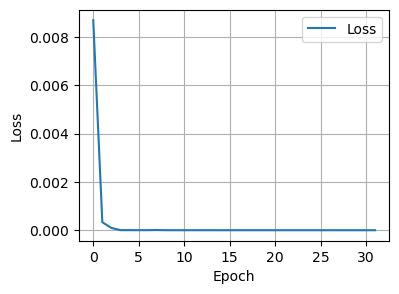

In [59]:
# plot a graph to analyze loss
fig, ax = plt.subplots(1, 1, figsize = (4, 3))
ax.plot(history.history['loss'], label='Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.show()

In [60]:
# reshape the input for prediction
def reshape_input(X_):
    '''
    Reshape all inputs
    '''
    for i in range(len(X_)):
        X_tmp = X_[i].reshape(1, 224, 224, 1)
        yield(X_tmp)

In [61]:
X_train_reshaped = reshape_input(X_train)
pred_train = colorizing_model.predict(X_train_reshaped)
pred_train = pred_train * 128

for i in range(len(pred_train)):
    pred_train[i] = pred_train[i].reshape(224, 224, 2)

2589/2589 [==============================] - 40s 15ms/step


In [62]:
X_test_reshaped = reshape_input(X_test)
pred_test = colorizing_model.predict(X_test_reshaped)
pred_test = pred_test * 128

for i in range(len(pred_test)):
    pred_test[i] = pred_test[i].reshape(224, 224, 2)

863/863 [==============================] - 13s 15ms/step


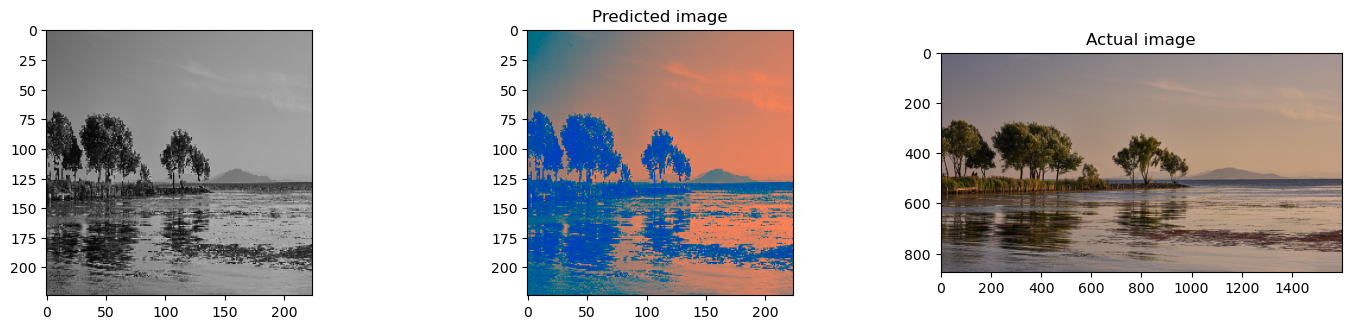

In [70]:
plt.figure(figsize=(30, 20))

plt.subplot(5, 5, 1) 

img = cv2.imread(rgb_img[3272])
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)


plt.subplot(5, 5, 2)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = pred_test[0]
img_ = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
plt.title('Predicted image')
plt.imshow(img_)
plt.savefig('pred_1.png')

plt.subplot(5, 5, 3)
plt.title('Actual image')
plt.imshow(img1)
plt.savefig('actual_1.png')

We observe that the model doesn't predict too well, as blue sky was predicted as orange-nish color. We would perform some evaluation metrics to measure the similarity between the images

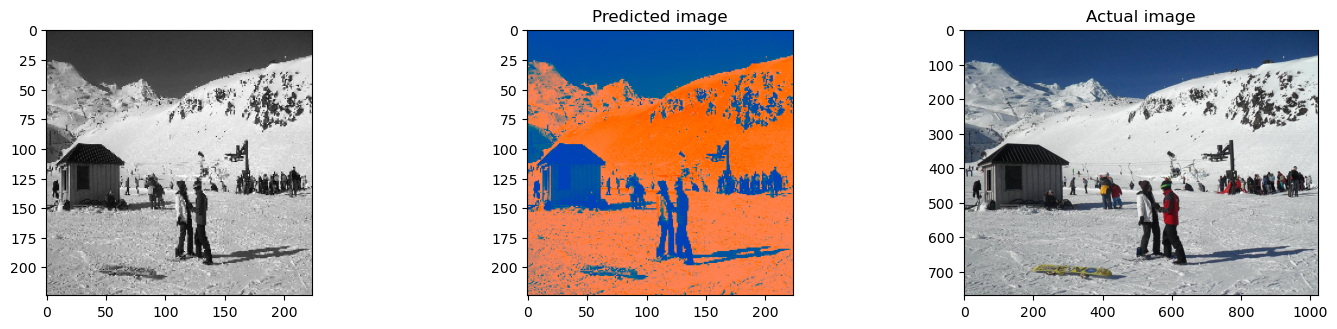

In [72]:
plt.figure(figsize=(30, 20))

plt.subplot(5, 5, 1) 

img = cv2.imread(rgb_img[60])
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)


plt.subplot(5, 5, 2)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = pred_train[60]
img_ = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
plt.title('Predicted image')
plt.imshow(img_)
plt.savefig('pred_1.png')

plt.subplot(5, 5, 3)
plt.title('Actual image')
plt.imshow(img1)
plt.savefig('actual_1.png')

## Evaluation

### Structural Similarity Index (SSIM)

SSIM is an evaluation metric commonly used in image generation problems. It is used for measuring the similarity between 2 images (prediction, actual).

#### Range
SSIM ranges from -1 to 1. The higher the SSIM score, the better the model performs. Thus, we would apply SSIM to maximize its score

#### Formula
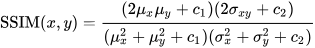

The description of the formula is found in: https://en.wikipedia.org/wiki/Structural_similarity

In [ ]:
# # extract grayscale channels and colored channels separately
# def extract_channel(rgb_images):
#     X_img = []
#     y_img = []
    
#     for img in rgb_images:
#         img = cv2.imread(img)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
#         img = img.astype(np.float32)
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        
#         img_resized = cv2.resize(img, (224, 224))
#         img_L = img_resized[:, :, 0]       # extract L channel
#         img_ab = img_resized[:, :, 1:]     # extract ab channels
        
#         # img_L = img_L / 100
#         img_ab = img_ab / 128     # scaled ab channels to range between -1 and 1
        
#         X_img.append(img_L)       # input is grayscale channel
#         y_img.append(img_ab)      # output is colored, ab channels
        
    
# #     X_img = np.array(X_img)     # we would retain the X and y in the image type, not converting into numpy arrays
# #     y_img = np.array(y_img)
    
#     return X_img, y_img

In [ ]:
# # making predictions
# # from sklearn.metrics import accuracy_score
# from skimage.metrics import structural_similarity as ssim

# accuracy_scores = []

# # we evaluate on the test set
# test_grayscale_images, test_color_images = extract_channel(rgb_img)
# test_grayscale_images_rs, test_color_images_rs = reshape_data(test_grayscale_images, test_color_images)

# for grayscale_image, actual_color_image in zip(test_grayscale_images_rs, test_color_images_rs):
#     colorized_image = colorizing_model.predict(np.expand_dims(grayscale_image, axis=0))
#     colorized_image = colorized_image.squeeze()
#     colorized_image = cv2.cvtColor(colorized_image, cv2.COLOR_RGB2BGR)
    
#     ssim_score = ssim(colorized_image, actual_color_image, multichannel=True)
#     accuracy_scores.append(ssim_score)
    
# mean_accuracy = np.mean(accuracy_scores)
# print(f"Average SSIM Accuracy: {mean_accuracy:.2f}")

In [73]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(pred, actual):
    '''
    Compute the structural similarity between 2 images
    '''
    pred_gray = cv2.cvtColor(pred, cv2.COLOR_RGB2GRAY)
    actual_gray = cv2.cvtColor(actual, cv2.COLOR_RGB2GRAY)              # SSIM typically works with grayscale images
    
    window_size = 11  # patch size
    dynamic_range = True  # use dynamic range for contrast calculation
    
    # calculate local SSIM scores
    ssim_scores = ssim(pred_gray, actual_gray, data_range=1.0, win_size=window_size, dynamic_range=dynamic_range)
    
    # calculate mean SSIM score
    mean_ssim = np.mean(ssim_scores)
    
    return mean_ssim

In [74]:
pred_1 = cv2.imread('pred_1.png')
actual_1 = cv2.imread('actual_1.png')

ssim_1 = compute_ssim(pred_1, actual_1)
print(f'SSIM score: {ssim_1}')

SSIM score: 0.9809536450521653


The score of similarity of the sample prediction above is pretty high, as it is close to 1. However, our two images do not look similar to each other.
We should address the following reasons:
- Issue with color rebalancing: SSIM might not capture the difference of color balance even though luminance and contrast do match
- Spatial misalignments: sometimes the colorized areas might be shifted and not aligned with the actual colors, and SSIM might still give a high score
- Limited context: SSIM typically works on local patches and might not work well on a global context of an image

Thus, we would explore other ways according to these above reasons.

### Frechet Inception Distance (FID)

## Inspiration
This notebook is inspired by: https://www.kaggle.com/code/basu369victor/image-colorization-basic-implementation-with-cnn